# Notes

Сьогодні ми розглянемо одну з найперших моделей моделі трансформера зі статті "Attention Is All You Need", а саме - Bert
 https://arxiv.org/pdf/1706.03762  

В статті автори побудували цю нейронну мержу для задачі машиного перекладу і використали відомі патерни з області пошуку інформації:
- Attention
- SelfAttention
- MultiheadAttention

Зараз подібні архітектури використовуються не лише для машиного перекладу, а і в інших задачах: клсифікація, генерація тексту, генерація зображень по опису, та опис зображень, тощо 

 
 Важлива частина в розробці алгоритму - реалізація, та перенавчання. Вам  щоб показати що модель дійсна здібна узагальнювати

## Bert schema

![bert_schama](bert)

In [129]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


# Опис даних

fetch_20newsgroups - дані із бібліотеки scikit-learn, які складаються із листів (необроблених), та 20-ти міток тем, до яких належать ці листи

Ваша задача (на бали):
- обробити ці тексти
- дописати модулі до архітектури неронної мережі
- навчити її параметри на навчальних даних і перевірити на тестових

https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.fetch_20newsgroups.html


In [130]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

len(newsgroups_train)

5

In [131]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [132]:
n_classes = len(newsgroups_train['target_names'])

In [133]:
print(newsgroups_train['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1

# Задачі по варіантам (модулям)

1. Токенізуйте текст, використавши `from nltk.tokenize import word_tokenize`, лематизуйте токени, використавши `nltk.stem.wordnet`
2. Токенізуйте текст, використавши `from nltk.tokenize import word_tokenize`, застосуйте стемінг до токенів, використавши `nltk.stem`
3. Розбийте текст на терми по 6 символів

Дайте відповідь на питання:
- чи є сенс всі символи перевести в нижній регістр?
- Як багато різних слів ви маєте до лематизації та стемінгу?

Посилання 
- https://www.nltk.org/api/nltk.stem.wordnet.html
- https://www.nltk.org/api/nltk.tokenize.html
- https://www.nltk.org/howto/stem.html

Терми можуть бути:
- слова
- послідовності слів
- окремі символи
- послідовності символів

In [134]:
from tensorflow.keras import layers
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from collections import Counter
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
import re
 
lemmatizer = WordNetLemmatizer()
def lemmatize_doc(doc):
    res = []
    for word in doc:
        if re.search(r'\w+', word):
            res.append(lemmatizer.lemmatize(word))

    return res

tokenized_texts = []
for doc in tqdm(newsgroups_train.data):
    processed = word_tokenize(doc)
    processed = lemmatize_doc(processed)
    tokenized_texts.append(processed)

  0%|          | 0/11314 [00:00<?, ?it/s]

100%|██████████| 11314/11314 [00:31<00:00, 359.64it/s]


In [135]:
from functools import reduce

all_words = []
for doc in tqdm(tokenized_texts):
    all_words.extend(doc)

words = set(all_words)
top_words = Counter(all_words)

100%|██████████| 11314/11314 [00:00<00:00, 440808.48it/s]


# Збір словника
Різних слів занадто багато (і це нормально). Тому ми беремо лише ті слова, яких більше 10 в нашому корпусі, та менше 1000
1. менше 10 - їх багато, але не часті
2. більше 1000 - їх небагато, але більше частина з них - стоп-слова (не несуть змістового навантаження)


In [136]:
vocab = [word for word, freq in top_words.items() if freq >= 10 and freq <= 1000]

(array([1.1092e+04, 1.3300e+02, 2.5000e+01, 1.2000e+01, 1.7000e+01,
        1.1000e+01, 7.0000e+00, 2.0000e+00, 7.0000e+00, 8.0000e+00]),
 array([   15. ,  1427.4,  2839.8,  4252.2,  5664.6,  7077. ,  8489.4,
         9901.8, 11314.2, 12726.6, 14139. ]),
 <BarContainer object of 10 artists>)

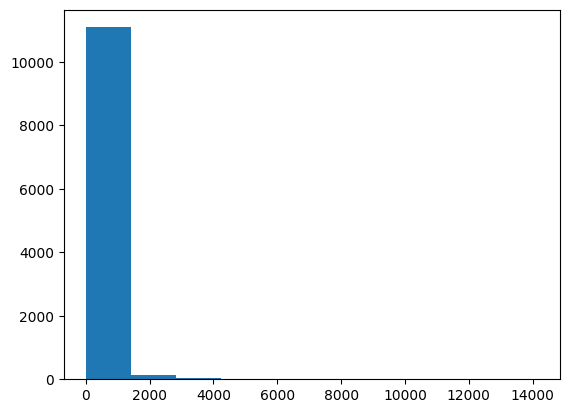

In [137]:
from matplotlib import pyplot as plt
plt.hist([len(i) for i in tokenized_texts])

In [138]:
import numpy as np

In [139]:
len(words)

198310

In [140]:
i2w = dict(enumerate(vocab))
w2i = {w: i for i, w in i2w.items()}

# max_seq_len

In [141]:
# Кодування текстів
max_seq_len = 256
x_texts = np.zeros((len(tokenized_texts), max_seq_len))

for ki, i in enumerate(tokenized_texts):
    if len(i) > max_seq_len:
        line = i[-max_seq_len:]
    else:
        line = i
    for wi, w in enumerate(line):
        x_texts[ki, wi] = w2i.get(w, len(w2i))

# Модель трансформера

В блоках далі реалізовано значно спрощену модель трансформера Bert, щоб можна було його навчати на CPU. Ваша задача - дописати його

Задачі:
- Дописати функцію get_output_block відповідно до схеми мережі, що вгорі

По варіантам, реалізувати різні FeedForward блоки
1. Dense, Dense
2. Conv1D, Dense
3. LSTM що повертає всі стани а не лище останній, Dense
4. Residual block (see wiki)

Посилання:
- https://en.wikipedia.org/wiki/Residual_neural_network
- resudal = conv(inp) + sigmoid(conv(inp))

In [142]:
def get_feed_forward(layer_one, neurons): # HERE YOUR CODE
    x = layers.Dense(neurons, activation='selu')(layer_one)
    x = layers.Dense(neurons, activation='selu')(x)

    return x

In [143]:
def get_feed_forward_test(layer_one, neurons):
    return layers.Dense(neurons, activation='selu')(layer_one)


def add_and_norm(a, b):
    return layers.BatchNormalization()(a + b)

def get_input_block(prev_block, neurons):
    # TODO: second param might be different
    mha = layers.MultiHeadAttention(2, 1)(prev_block, prev_block, prev_block)
    layer_one = add_and_norm(mha, prev_block)

    ff = get_feed_forward(layer_one, neurons)
    layer_two = add_and_norm(ff, layer_one)
    return layer_two


def get_output_block(prev_block, parallel_input, neurons): # Цей я пропоную сховати, щоб студенти самі написали
    # WRITE YOUR CODE (based on tokenized_texts variable)
    mha = layers.MultiHeadAttention(2, 1)(prev_block, parallel_input, parallel_input)
    layer_one = add_and_norm(mha, prev_block)

    ff = get_feed_forward_test(layer_one, neurons)
    layer_two = add_and_norm(ff, layer_one)
    return layer_two

# Ембедер

Ми використовуємо простий ембедер для тексту, а вам пропонуємо зробити його складнішим
Варіанти
1. return "Embedding + Conv1D + LSTM(який всі стани повертає)"
2. return "Embedding + Conv1D + Dense"
3. return "Embedding + Dense + LSTM(який всі стани повертає)"

In [144]:
def embedder(input):
    embedder = layers.Embedding(len(vocab) + 1, 16)(input) # HERE SHOULD BE YOUR CODE
    embedder = layers.Conv1D(16, 1)(embedder)
    embedder = layers.LSTM(16, return_sequences=True)(embedder)
    return embedder

In [145]:
from keras_hub.layers import SinePositionEncoding

In [146]:
inp = layers.Input((max_seq_len,))
out = layers.Input((max_seq_len,))


input_emb = embedder(inp)
output_emb = embedder(out)

N = 2

# TODO: specify heads
neurons = [16, 16]

inp_blocks = [input_emb]
out_blocks = [output_emb]

pos_emb = SinePositionEncoding(max_wavelength=1000)(inp_blocks[-1])
inp_blocks.append(inp_blocks[-1] + pos_emb)

for i in range(N):
    # TODO: add sinusoidal positional encoding
    inp_block = get_input_block(inp_blocks[-1], neurons[i])
    out_block = get_output_block(out_blocks[-1], inp_block, neurons[i])

    inp_blocks.append(inp_block)
    out_blocks.append(out_block)

manticora_head = layers.GlobalMaxPool1D()(out_blocks[-1])
manticora_head = layers.Dense(128, activation='linear')(manticora_head)
manticora_head = layers.Dense(n_classes, activation='softmax')(manticora_head)

In [161]:
from tensorflow import keras
model = keras.Model([inp, out], manticora_head)

In [162]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 256, 16)   │    330,320 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 256, 16)   │        272 │ embedding_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 256, 16)   │      2,112 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_position_enco… │ (None, 256, 16)   │          0 │ lstm_16[0][0]     │
│ (SinePositionEncod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_65 (Add)        │ (None, 256, 16)   │          0 │ lstm_16[0][0],    │
│                     │                   │            │ sine_position_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 16)   │        150 │ add_65[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_65[0][0],     │
│                     │                   │            │ add_65[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_66 (Add)        │ (None, 256, 16)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_65[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ add_66[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 256, 16)   │        272 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 256, 16)   │        272 │ dense_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 256, 16)   │    330,320 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_67 (Add)        │ (None, 256, 16)   │          0 │ dense_61[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 256, 16)   │        272 │ embedding_17[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ add_67[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 256, 16)   │      2,112 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 16)   │        150 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat

 Total params: 672,908 (2.57 MB)

 Trainable params: 672,652 (2.57 MB)

 Non-trainable params: 256 (1.00 KB)

In [166]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-3), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [167]:
np.random.seed(42)

idx = np.arange(x_texts.shape[0])
np.random.shuffle(idx)

train_size = int(0.8 * x_texts.shape[0])
train_idx = idx[:train_size]
test_idx = idx[train_size:]

x_texts_train = x_texts[train_idx, :]
x_texts_test = x_texts[test_idx, :]

In [168]:
# TODO: shuffle train, test
# model.fit([x_texts, x_texts], newsgroups_train['target'])
import keras.callbacks

batch_end_loss = []
class SaveBatchLoss(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        batch_end_loss.append(logs['loss'])

history = model.fit([x_texts_train, x_texts_train], newsgroups_train['target'][train_idx], epochs=10, callbacks=SaveBatchLoss())

Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 59s 178ms/step - accuracy: 0.6478 - loss: 1.1421
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - accuracy: 0.8530 - loss: 0.4790
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - accuracy: 0.9117 - loss: 0.2661
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - accuracy: 0.9532 - loss: 0.1511
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - accuracy: 0.9673 - loss: 0.1129
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - accuracy: 0.9663 - loss: 0.0984
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.9667 - loss: 0.1057
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - accuracy: 0.9627 - loss: 0.1189
Epoch 9/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 51s 178ms/step - accuracy: 0.9774 - loss: 0.0714
Epoch 10/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.9697 - loss: 0.0895


In [169]:
model.evaluate([x_texts, x_texts], newsgroups_train['target'])


354/354 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9326 - loss: 0.3991


[0.4024512469768524, 0.9315007925033569]

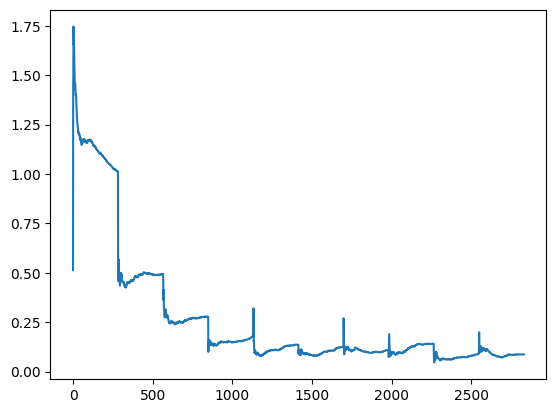

In [170]:
plt.plot(batch_end_loss)

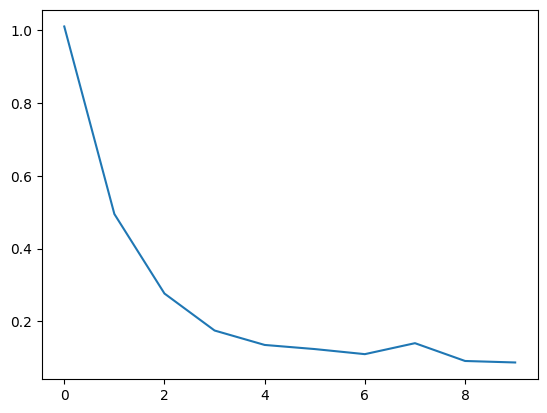

In [173]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

# Задачі до навчання:
- Зробіть train-test split (Варіант 1: 80-20, варіант 2: 66-34)
- Чи добре навчена модель?

Варіанти:
1. навчіть логістичну регресію, яка б по CountVectorizer класифікувала тексти. Чи працює вона краще за Bert?
2. навчіть градієнтний бустінг, який би по TfIdf класифікував тексти. Чи працює він краще за Bert?
3. навчіть випадкове дерево, яке б по CountVectorizer класифікувало тексти. Чи працює воно краще за Bert?
4. навчіть випадковий ліс, якt б по TfIdf класифікував тексти. Чи працює він краще за Bert?
5. навчіть наївний баєсівський класифікатор, який би по CountVectorizer класифікував тексти. Чи працює він краще за Bert?

Посилання
- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- Всі інші моделі шукайте тут https://scikit-learn.org/1.5/supervised_learning.html

In [126]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(newsgroups_train.data)

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, y_train = X[train_idx], newsgroups_train['target'][train_idx]
X_test, y_test = X[test_idx], newsgroups_train['target'][test_idx]

model = LogisticRegression(max_iter=1000, random_state=42)  # Більше ітерацій для великих текстів
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8784798939460893


# Напишіть звіт
- Чи застосування Bert дало кращі результати?
- Чи є сенс оброблювати словник саме для задачі класифікації? 
- Для яких задач, стемінг та лематизацію ні в якому разі не можна застосовувати